In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Car.csv')

In [4]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [5]:
df.isna().sum()

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,221
engine,221


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [7]:

if df['mileage'].dtype == 'object':
    df['mileage'] = pd.to_numeric(df['mileage'].str.replace(' kmpl', '').str.replace(' km/kg', ''), errors='coerce')

In [8]:

if df['engine'].dtype == 'object':
    df['engine'] = pd.to_numeric(df['engine'].str.replace(' CC', ''), errors='coerce')

In [9]:

if df['max_power'].dtype == 'object':
    df['max_power'] = pd.to_numeric(df['max_power'].str.replace(' bhp', ''), errors='coerce')

In [10]:
df['torque'] = df['torque'].astype(str)
df['torque'] = pd.to_numeric(df['torque'].str.extract(r'(\d+\.?\d*)', expand=False), errors='coerce')

selling_price    1.000000
max_power        0.748489
torque           0.619792
engine           0.455734
year             0.414092
seats            0.041358
mileage         -0.126054
km_driven       -0.225534
Name: selling_price, dtype: float64


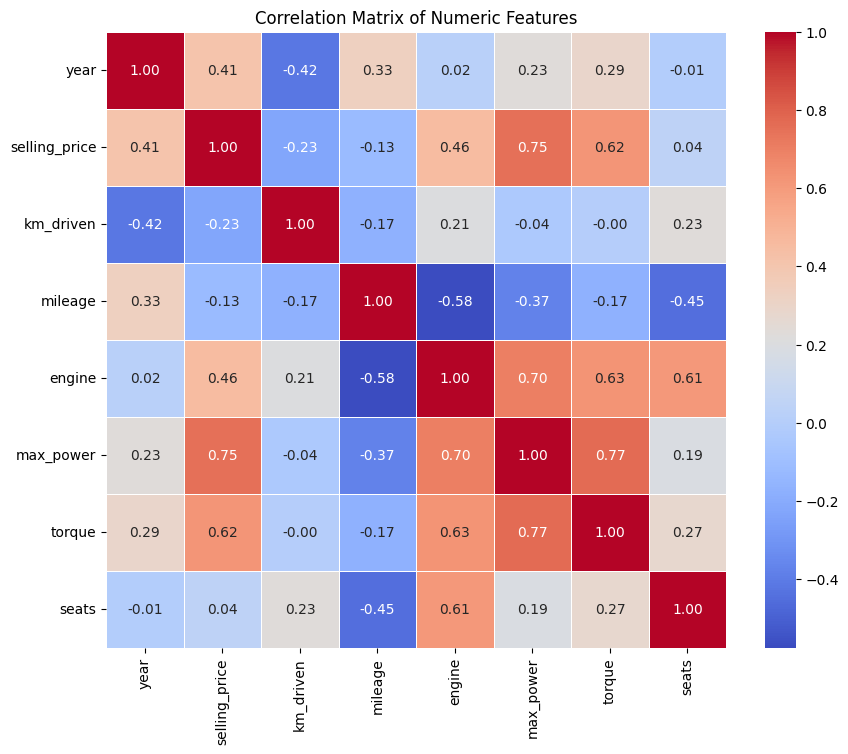

In [11]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

correlation_matrix = df[numeric_cols].corr()

selling_price_correlation = correlation_matrix['selling_price'].sort_values(ascending=False)

print(selling_price_correlation)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [12]:
features_to_check = ['max_power', 'engine', 'year', 'torque', 'km_driven', 'mileage']
skewness_report = df[features_to_check].skew()
print(skewness_report)

max_power     1.621261
engine        1.135269
year         -1.072293
torque        1.060241
km_driven    11.170910
mileage      -0.142667
dtype: float64


In [13]:
skewed_features = ['km_driven', 'engine', 'max_power', 'seats', 'year', 'torque']
for col in skewed_features:
    df[col] = np.log1p(df[col])
print(df[skewed_features].skew())

km_driven   -1.247396
engine       0.416622
max_power   -1.003220
seats        1.648795
year        -1.080033
torque      -1.365012
dtype: float64


In [14]:
df['mileage'].fillna(df['mileage'].mean(), inplace=True)

In [15]:
df['engine'].fillna(df['engine'].mean(), inplace=True)

In [16]:
df['max_power'].fillna(df['max_power'].median(), inplace=True)
df['seats'].fillna(df['seats'].median(), inplace=True)

In [17]:
df['selling_price_log'] = np.log1p(df['selling_price'])

In [18]:
X = df.drop(['selling_price','selling_price_log'],axis=1)
y = df['selling_price_log']

In [19]:
if 'name' in df.columns:
    df['brand'] = df['name'].apply(lambda x: x.split()[0])
    df = df.drop(columns=['name'])
else:
    print("'name' column not found in DataFrame. Skipping brand creation and column drop.")

In [20]:
print("Skewness of selling_price (y):", y.skew())

Skewness of selling_price (y): 0.22327004522860716


In [21]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [24]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_encoded.columns)

X_scaled_df.head()

,year,km_driven,mileage,engine,max_power,torque,seats,name_Ambassador Classic 2000 DSZ AC PS,name_Ambassador Grand 1500 DSZ BSIII,name_Ambassador Grand 2000 DSZ PW CL,...,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Manual,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,0.049413,1.175275,0.999896,-0.326011,-0.394664,0.445342,-0.424288,-0.011093,-0.011093,-0.011093,...,0.920018,-0.068536,-0.89857,0.448665,-0.172927,0.385158,-0.147905,-0.591180,-0.02481,-0.270715
1,0.049413,0.954930,0.432289,0.253151,0.520547,0.821101,-0.424288,-0.011093,-0.011093,-0.011093,...,0.920018,-0.068536,-0.89857,0.448665,-0.172927,0.385158,-0.147905,1.691533,-0.02481,-0.270715
2,-1.930425,1.131210,-0.431678,0.251033,-0.251381,-3.178933,-0.424288,-0.011093,-0.011093,-0.011093,...,-1.086935,-0.068536,1.11288,0.448665,-0.172927,0.385158,-0.147905,-0.591180,-0.02481,3.693920
3,-0.939522,1.019764,0.899435,0.029456,0.138571,-2.442573,-0.424288,-0.011093,-0.011093,-0.011093,...,0.920018,-0.068536,-0.89857,0.448665,-0.172927,0.385158,-0.147905,-0.591180,-0.02481,-0.270715
4,-1.682514,0.954930,-0.833524,-0.201416,0.083479,-3.305022,-0.424288,-0.011093,-0.011093,-0.011093,...,-1.086935,-0.068536,1.11288,0.448665,-0.172927,0.385158,-0.147905,-0.591180,-0.02481,-0.270715


In [25]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
skewness_report_numeric = df[numeric_cols].skew()
print("Skewness Report for All Numeric Columns:")
print(skewness_report_numeric)

Skewness Report for All Numeric Columns:
year                -1.080033
selling_price        4.193533
km_driven           -1.247396
mileage             -0.144647
engine               0.422402
max_power           -1.006874
torque              -1.365012
seats                1.692397
selling_price_log    0.223270
dtype: float64


In [26]:
imputer = SimpleImputer(strategy='median')
X_scaled_imputed = imputer.fit_transform(X_scaled_df)
X_scaled_imputed_df = pd.DataFrame(X_scaled_imputed, columns=X_scaled_df.columns)

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled_imputed_df, y, test_size=0.2, random_state=42)

In [318]:
lr_model = LinearRegression()

imputer = SimpleImputer(strategy='median')
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
X_test_scaled_imputed = imputer.transform(X_test_scaled)

lr_model.fit(X_train_scaled_imputed, y_train)

LinearRegression()

In [319]:
y_pred_log = lr_model.predict(X_test_scaled_imputed)

y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

r2 = r2_score(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print("--- Linear Regression Model Performance ---")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (in REAL RUPEES): Rs. {mae:,.2f}")
print(f"RMSE (in REAL RUPEES): Rs. {rmse:,.2f}")

--- Linear Regression Model Performance ---
R-squared: 0.9010
Mean Absolute Error (in REAL RUPEES): Rs. 94,052.28
RMSE (in REAL RUPEES): Rs. 254,702.34


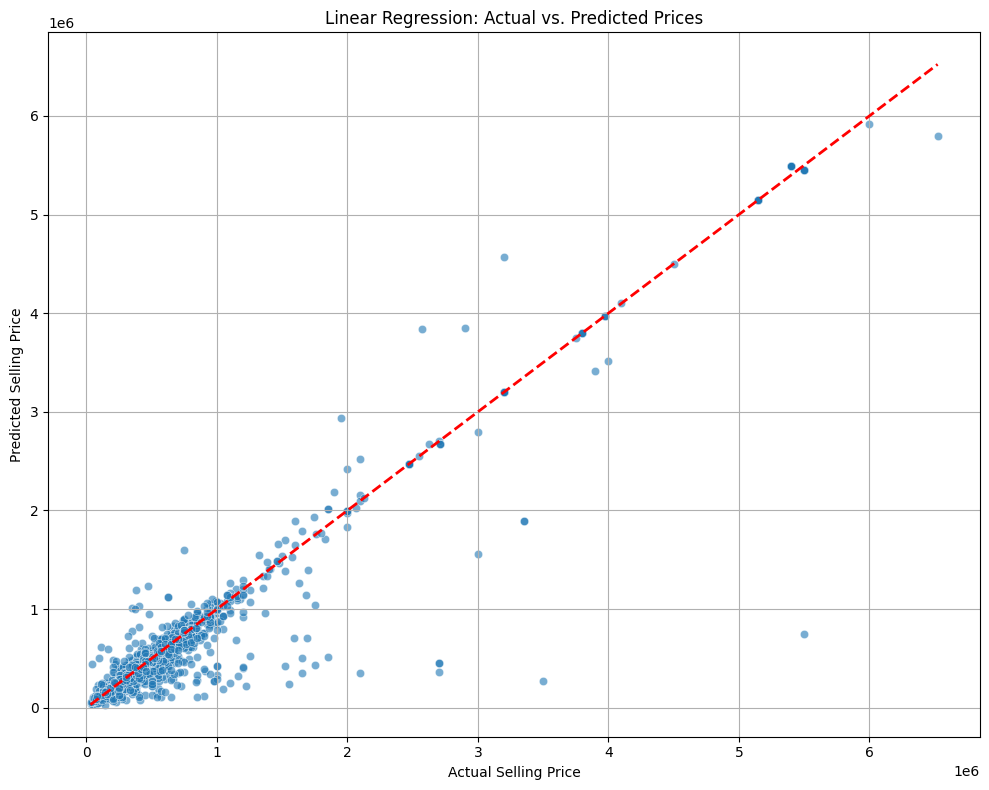

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Linear Regression: Actual vs. Predicted Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import Lasso, Ridge

In [60]:
ridge = Ridge(random_state=42)
ridge.fit(X_train_scaled, y_train)

Ridge(random_state=42)

In [61]:
y_pred_ridge_log = ridge.predict(X_test_scaled)

y_pred_ridge_actual = np.expm1(y_pred_ridge_log)
y_test_original = np.expm1(y_test)


r2_ridge = r2_score(y_test_original, y_pred_ridge_actual)
mae_ridge = mean_absolute_error(y_test_original, y_pred_ridge_actual)
rmse_ridge = np.sqrt(mean_squared_error(y_test_original, y_pred_ridge_actual))

print("--- Ridge Model Performance ---")
print(f"R-squared: {r2_ridge:.4f}")
print(f"Mean Absolute Error (in REAL RUPEES): Rs. {mae_ridge:,.2f}")
print(f"RMSE (in REAL RUPEES): Rs. {rmse_ridge:,.2f}")

--- Ridge Model Performance ---
R-squared: 0.9175
Mean Absolute Error (in REAL RUPEES): Rs. 86,493.41
RMSE (in REAL RUPEES): Rs. 232,494.37


In [46]:
ridge = Ridge(random_state=42)

cv_scores_ridge = cross_val_score(
    ridge,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
print("Ridge Cross-Validation R² scores:", cv_scores_ridge)
print("Mean CV R²:", cv_scores_ridge.mean())

Ridge Cross-Validation R² scores: [0.85104412 0.87647082 0.87317014 0.86379176 0.85287505]
Mean CV R²: 0.8634703784982959


In [50]:
from sklearn.linear_model import Lasso

lasso_instance = Lasso()

In [51]:
from sklearn.linear_model import Lasso
lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

In [52]:
lasso_random_search = RandomizedSearchCV(
    estimator=lasso_instance,
    param_distributions=lasso_param_grid,
    n_iter=6,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lasso_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=6, n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0,
                                                  100.0]},
                   random_state=42, scoring='r2', verbose=2)

In [62]:
best_lasso_model = lasso_random_search.best_estimator_
y_pred_lasso_tuned_log = best_lasso_model.predict(X_test_scaled)

y_pred_lasso_tuned_actual = np.expm1(y_pred_lasso_tuned_log)

r2_lasso_tuned = r2_score(y_test_original, y_pred_lasso_tuned_actual)
mae_lasso_tuned = mean_absolute_error(y_test_original, y_pred_lasso_tuned_actual)
rmse_lasso_tuned = np.sqrt(mean_squared_error(y_test_original, y_pred_lasso_tuned_actual))

print("--- Tuned Lasso Model Performance ---")
print(f"Best Alpha: {lasso_random_search.best_params_['alpha']}")
print(f"R-squared: {r2_lasso_tuned:.4f}")
print(f"Mean Absolute Error (in REAL RUPEES): Rs. {mae_lasso_tuned:,.2f}")
print(f"RMSE (in REAL RUPEES): Rs. {rmse_lasso_tuned:,.2f}")

--- Tuned Lasso Model Performance ---
Best Alpha: 0.001
R-squared: 0.9536
Mean Absolute Error (in REAL RUPEES): Rs. 76,630.29
RMSE (in REAL RUPEES): Rs. 174,334.05


In [63]:
lasso_cv_model = Lasso(alpha=lasso_random_search.best_params_['alpha'], random_state=42)
cv_scores_lasso = cross_val_score(lasso_cv_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("---- Cross-Validation R² Scores for Tuned Lasso ----")
print("CV R² scores:", cv_scores_lasso)
print("Mean CV R²:", cv_scores_lasso.mean())

---- Cross-Validation R² Scores for Tuned Lasso ----
CV R² scores: [0.9171491  0.91995343 0.91444005 0.91638174 0.91834101]
Mean CV R²: 0.9172530643995579


In [339]:
X_train_scaled, X_test_scaled, y_train_log_split, y_test_log_split = train_test_split( X_scaled_df, y, test_size=0.2, random_state=42)

y_test_original = np.expm1(y_test_log_split)
rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)
rf_random_search.fit(X_train_scaled, y_train_log_split)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 15, 20, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='r2', verbose=2)

 Best Parameters Found:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}

 Random Forest Regressor Performance (on Original Scale):
R² Score  : 0.9658
MAE       : Rs. 68,254.53
RMSE      : Rs. 149,625.84


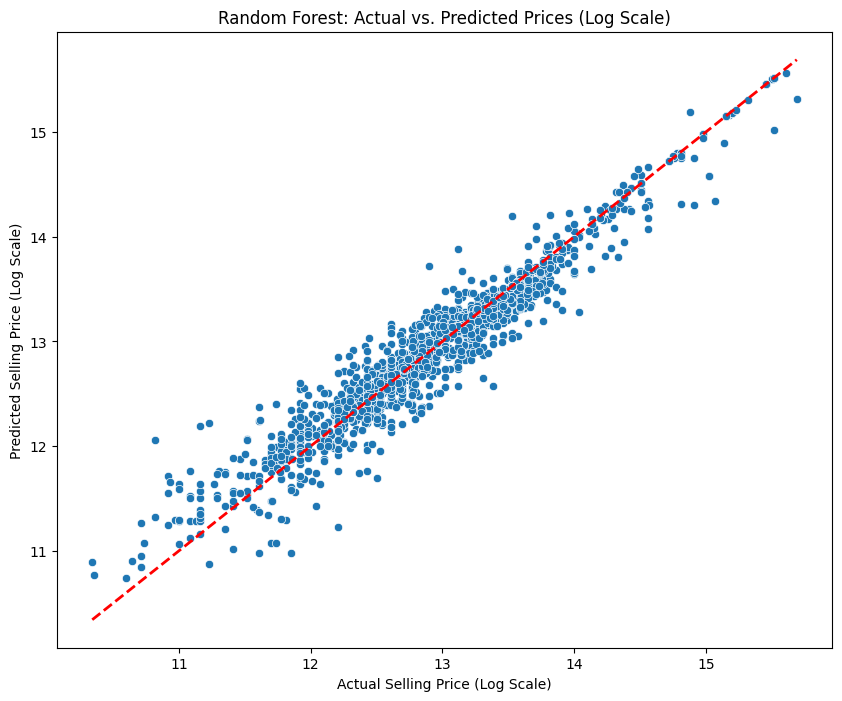

In [341]:
best_rf_model = rf_random_search.best_estimator_
y_pred_rf_log = best_rf_model.predict(X_test_scaled)

y_pred_rf_original = np.expm1(y_pred_rf_log)

r2_rf_real = r2_score(y_test_original, y_pred_rf_original)
mae_rf_real = mean_absolute_error(y_test_original, y_pred_rf_original)
rmse_rf_real = np.sqrt(mean_squared_error(y_test_original, y_pred_rf_original))

print(" Best Parameters Found:")
print(rf_random_search.best_params_)
print("\n Random Forest Regressor Performance (on Original Scale):")
print(f"R² Score  : {r2_rf_real:.4f}")
print(f"MAE       : Rs. {mae_rf_real:,.2f}")
print(f"RMSE      : Rs. {rmse_rf_real:,.2f}")

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_log_split, y=y_pred_rf_log)
plt.plot([y_test_log_split.min(), y_test_log_split.max()],
         [y_test_log_split.min(), y_test_log_split.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Selling Price (Log Scale)")
plt.ylabel("Predicted Selling Price (Log Scale)")
plt.title("Random Forest: Actual vs. Predicted Prices (Log Scale)")
plt.show()

In [342]:
y_train_pred_rf_log = best_rf_model.predict(X_train_scaled)

y_train_original = np.expm1(y_train_log_split)
y_train_pred_rf_original = np.expm1(y_train_pred_rf_log)

r2_rf_train_real = r2_score(y_train_original, y_train_pred_rf_original)
mae_rf_train_real = mean_absolute_error(y_train_original, y_train_pred_rf_original)

print("--- Tuned Random Forest Model Performance on Training Set ---")
print(f"  R-squared: {r2_rf_train_real:.4f}")
print(f"  Mean Absolute Error (in REAL RUPEES): Rs. {mae_rf_train_real:,.2f}")

print("\n--- Tuned Random Forest Model Performance on Test Set ---")
print(f"  R-squared: {r2_rf_real:.4f}")
print(f"  Mean Absolute Error (in REAL RUPEES): Rs. {mae_rf_real:,.2f}")

--- Tuned Random Forest Model Performance on Training Set ---
  R-squared: 0.9879
  Mean Absolute Error (in REAL RUPEES): Rs. 27,119.94

--- Tuned Random Forest Model Performance on Test Set ---
  R-squared: 0.9658
  Mean Absolute Error (in REAL RUPEES): Rs. 68,254.53


In [343]:
rf = RandomForestRegressor(**rf_random_search.best_params_, random_state=42)
cv_scores = cross_val_score(rf, X_train_scaled, y_train_log_split, cv=5, scoring='r2')
print("Cross-Validation R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

Cross-Validation R² scores: [0.93087155 0.93311636 0.92405939 0.9296034  0.93087983]
Mean CV R²: 0.9297061057110698


In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

In [ ]:
lgbm_model = LGBMRegressor(random_state=42)

X_train_scaled.columns = pd.Series(X_train_scaled.columns).apply(lambda x: "".join (c if c.isalnum() else "_" for c in str(x)))
X_test_scaled.columns = pd.Series(X_test_scaled.columns).apply(lambda x: "".join (c if c.isalnum() else "_" for c in str(x)))

cols = pd.Series(X_train_scaled.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
X_train_scaled.columns = cols

cols = pd.Series(X_test_scaled.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
X_test_scaled.columns = cols

lgbm_model.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1195
[LightGBM] [Info] Number of data points in the train set: 6502, number of used features: 62
[LightGBM] [Info] Start training from score 12.973545


LGBMRegressor(random_state=42)

In [ ]:
y_pred_lgbm_log = lgbm_model.predict(X_test_scaled)

In [ ]:
y_pred_lgbm_original = np.expm1(y_pred_lgbm_log)

r2_lgbm_real = r2_score(y_test_original, y_pred_lgbm_original)
mae_lgbm_real = mean_absolute_error(y_test_original, y_pred_lgbm_original)

print("--- LightGBM Model Performance ---")
print(f"  R-squared: {r2_lgbm_real:.4f}")
print(f"  Mean Absolute Error (in REAL RUPEES): Rs. {mae_lgbm_real:,.2f}")

--- LightGBM Model Performance ---
  R-squared: 0.9668
  Mean Absolute Error (in REAL RUPEES): Rs. 73,769.34


In [ ]:
lgbm_model = LGBMRegressor(random_state=42)

X_train_scaled.columns = pd.Series(X_train_scaled.columns).apply(lambda x: "".join (c if c.isalnum() else "_" for c in str(x)))
y_train.name = "".join (c if c.isalnum() else "_" for c in str(y_train.name))

cols = pd.Series(X_train_scaled.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
X_train_scaled.columns = cols

param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [7, 10, 15, -1],
    'num_leaves': [31, 50, 70],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.001, 0.01],
    'reg_lambda': [0, 0.001, 0.01],
    'min_split_gain': [0, 0.01]
}

random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1195
[LightGBM] [Info] Number of data points in the train set: 6502, number of used features: 62
[LightGBM] [Info] Start training from score 12.973545


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [7, 10, 15, -1],
                                        'min_child_samples': [5, 10, 20],
                                        'min_split_gain': [0, 0.01],
                                        'n_estimators': [100, 150, 200],
                                        'num_leaves': [31, 50, 70],
                                        'reg_alpha': [0, 0.001, 0.01],
                                        'reg_lambda': [0, 0.001, 0.01],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [ ]:
best_lgbm_model = random_search.best_estimator_

print("Best Parameters:")
print(random_search.best_params_)
best_lgbm_params = random_search.best_params_
lgbm_model_tuned = LGBMRegressor(**best_lgbm_params, random_state=42)

X_train_scaled.columns = pd.Series(X_train_scaled.columns).apply(lambda x: "".join (c if c.isalnum() else "_" for c in str(x)))

cols = pd.Series(X_train_scaled.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
X_train_scaled.columns = cols

lgbm_model_tuned.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1195
[LightGBM] [Info] Number of data points in the train set: 6502, number of used features: 62
[LightGBM] [Info] Start training from score 12.973545


LGBMRegressor(colsample_bytree=0.8, min_split_gain=0, n_estimators=150,
              random_state=42, reg_alpha=0, reg_lambda=0, subsample=0.8)

In [ ]:
y_pred_lgbm_tuned_log = lgbm_model_tuned.predict(X_test_scaled)

In [ ]:
y_pred_lgbm_tuned_original = np.expm1(y_pred_lgbm_tuned_log)

r2_lgbm_tuned_real = r2_score(y_test_original, y_pred_lgbm_tuned_original)
mae_lgbm_tuned_real = mean_absolute_error(y_test_original, y_pred_lgbm_tuned_original)

print("--- Tuned LightGBM Model Performance ---")
print(f"  R-squared: {r2_lgbm_tuned_real:.4f}")
print(f"  Mean Absolute Error (in REAL RUPEES): Rs. {mae_lgbm_tuned_real:,.2f}")

--- Tuned LightGBM Model Performance ---
  R-squared: 0.9714
  Mean Absolute Error (in REAL RUPEES): Rs. 70,109.47


In [ ]:
best_lgbm_model = random_search.best_estimator_

X_train_scaled.columns = pd.Series(X_train_scaled.columns).apply(lambda x: "".join (c if c.isalnum() else "_" for c in str(x)))

cols = pd.Series(X_train_scaled.columns)
for dup in cols[cols.duplicated()].unique():
    cols[cols[cols == dup].index.values.tolist()] = [dup + '_' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
X_train_scaled.columns = cols

cv_scores = cross_val_score(best_lgbm_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("Cross-Validation R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))
print("Standard Deviation of CV R²:", np.std(cv_scores))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1126
[LightGBM] [Info] Number of data points in the train set: 5201, number of used features: 45
[LightGBM] [Info] Start training from score 12.969514
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1133
[LightGBM] [Info] Number of data points in the train set: 5201, number of used features: 46
[LightGBM] [Info] Start training from score 12.978715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 5202, number of used features: 47
[LightGBM] [Info] Start trai

In [ ]:
y_train_pred_lgbm_tuned_log = lgbm_model_tuned.predict(X_train_scaled)
y_train_pred_lgbm_tuned_original = np.expm1(y_train_pred_lgbm_tuned_log)

r2_lgbm_tuned_train_real = r2_score(y_train_original, y_train_pred_lgbm_tuned_original)
mae_lgbm_tuned_train_real = mean_absolute_error(y_train_original, y_train_pred_lgbm_tuned_original)

print("--- Tuned LightGBM Model Performance on Training Set ---")
print(f"  R-squared: {r2_lgbm_tuned_train_real:.4f}")
print(f"  Mean Absolute Error (in REAL RUPEES): Rs. {mae_lgbm_tuned_train_real:,.2f}")

print("\n--- Tuned LightGBM Model Performance on Test Set ---")
print(f"  R-squared: {r2_lgbm_tuned_real:.4f}")
print(f"  Mean Absolute Error (in REAL RUPEES): Rs. {mae_lgbm_tuned_real:,.2f}")

--- Tuned LightGBM Model Performance on Training Set ---
  R-squared: 0.9862
  Mean Absolute Error (in REAL RUPEES): Rs. 50,602.70

--- Tuned LightGBM Model Performance on Test Set ---
  R-squared: 0.9708
  Mean Absolute Error (in REAL RUPEES): Rs. 69,275.86


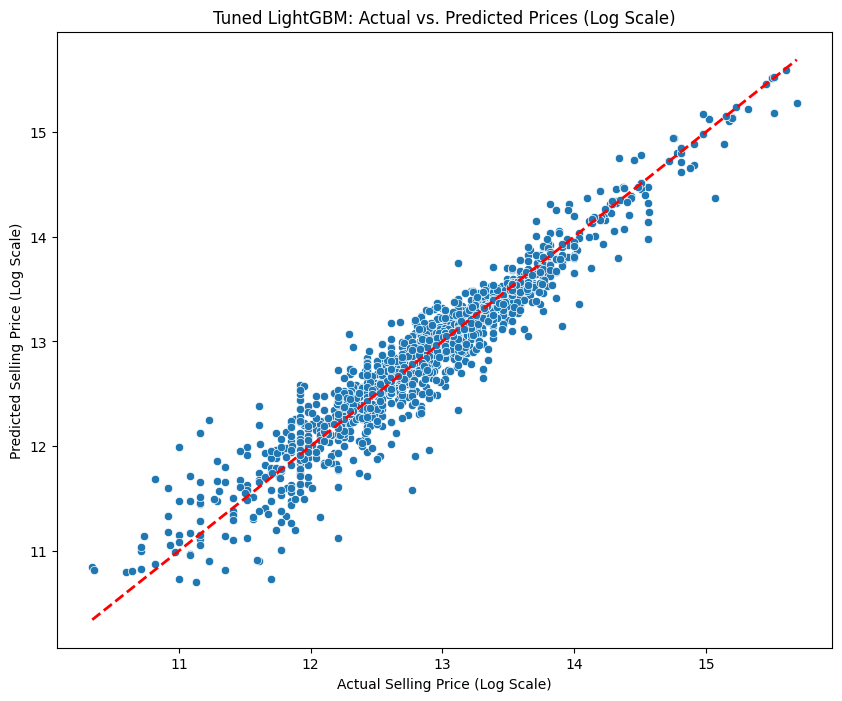

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred_lgbm_tuned_log)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Selling Price (Log Scale)")
plt.ylabel("Predicted Selling Price (Log Scale)")
plt.title("Tuned LightGBM: Actual vs. Predicted Prices (Log Scale)")
plt.show()

In [ ]:
imputer = SimpleImputer(strategy='median')
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

gbr_model = GradientBoostingRegressor(random_state=42)

gbr_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

random_search_gbr = RandomizedSearchCV(
    estimator=gbr_model,
    param_distributions=gbr_param_grid,
    n_iter=50,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_gbr.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=2)

In [ ]:
best_gbr_params = random_search_gbr.best_params_
print("Best GBR Parameters:")
print(best_gbr_params)

gbr_model_tuned = GradientBoostingRegressor(**best_gbr_params, random_state=42)
gbr_model_tuned.fit(X_train_scaled, y_train)

Best GBR Parameters:
{'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.05}


GradientBoostingRegressor(learning_rate=0.05, max_depth=7, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=150,
                          random_state=42, subsample=0.8)

In [ ]:
gbr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('gbr', gbr_model_tuned)
])
cv_scores = cross_val_score(
    gbr_pipeline,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
print("\nCross-Validation R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))
print("Standard Deviation of CV R²:", np.std(cv_scores))


Cross-Validation R² scores: [0.93104943 0.93968977 0.92291628 0.93569846 0.93326736]
Mean CV R²: 0.932524260637058
Standard Deviation of CV R²: 0.00559393732402652


In [ ]:
y_pred_test_log = gbr_model_tuned.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

y_pred_train_log = gbr_model_tuned.predict(X_train_scaled)
y_pred_train = np.expm1(y_pred_train_log)

r2_test = r2_score(y_test_original, y_pred_test)
mae_test = mean_absolute_error(y_test_original, y_pred_test)

r2_train = r2_score(y_train_original, y_pred_train)
mae_train = mean_absolute_error(y_train_original, y_pred_train)

print("\n--- Tuned GBR Performance on Training Set ---")
print(f"  R-squared: {r2_train:.4f}")
print(f"  MAE: Rs. {mae_train:,.2f}")

print("\n--- Tuned GBR Performance on Test Set ---")
print(f"  R-squared: {r2_test:.4f}")
print(f"  MAE: Rs. {mae_test:,.2f}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best GBR Parameters:
{'subsample': 0.8, 'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 7, 'learning_rate': 0.05}

--- Tuned GBR Performance on Training Set ---
  R-squared: 0.9836
  MAE: Rs. 56,599.95

--- Tuned GBR Performance on Test Set ---
  R-squared: 0.9721
  MAE: Rs. 71,918.82


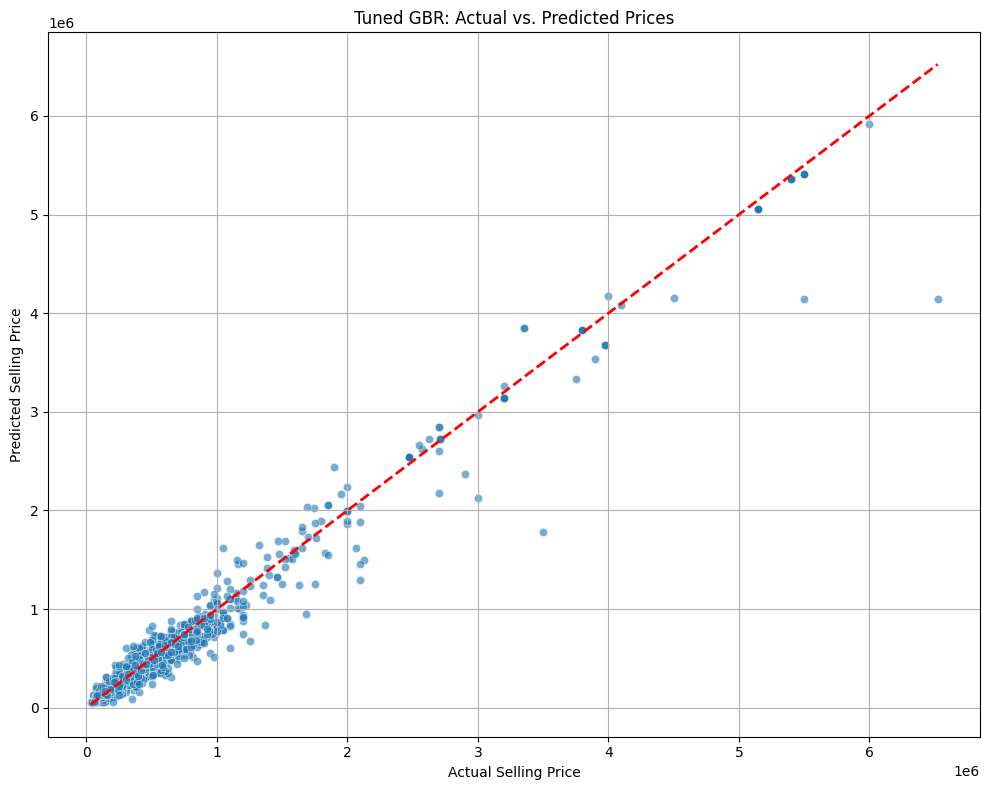

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test_original, y=y_pred_test, alpha=0.6)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Tuned GBR: Actual vs. Predicted Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
y_pred_dt_log = dt_model.predict(X_test_scaled)

y_pred_dt_actual = np.expm1(y_pred_dt_log)

r2_dt = r2_score(y_test_original, y_pred_dt_actual)
mae_dt = mean_absolute_error(y_test_original, y_pred_dt_actual)
rmse_dt = np.sqrt(mean_squared_error(y_test_original, y_pred_dt_actual))

print("--- Decision Tree Model Performance ---")
print(f"R-squared: {r2_dt:.4f}")
print(f"Mean Absolute Error (in REAL RUPEES): Rs. {mae_dt:,.2f}")
print(f"RMSE (in REAL RUPEES): Rs. {rmse_dt:,.2f}")

--- Decision Tree Model Performance ---
R-squared: 0.9612
Mean Absolute Error (in REAL RUPEES): Rs. 76,840.01
RMSE (in REAL RUPEES): Rs. 159,434.58


In [324]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV

In [333]:
elastic_net_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [326]:
elastic_net = ElasticNet(random_state=42)

elastic_net_random_search = RandomizedSearchCV(
    estimator=elastic_net,
    param_distributions=elastic_net_param_grid,
    n_iter=50,
    cv=5,
    scoring='r2',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

elastic_net_random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=ElasticNet(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0,
                                                  100.0],
                                        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
                   random_state=42, scoring='r2', verbose=2)

In [327]:
best_elastic_net_model = elastic_net_random_search.best_estimator_
best_elastic_net_model.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=42)

In [328]:
y_pred_elastic_net_log = best_elastic_net_model.predict(X_test_scaled)
y_pred_elastic_net_actual = np.expm1(y_pred_elastic_net_log)

r2_elastic_net = r2_score(y_test_actual, y_pred_elastic_net_actual)
mae_elastic_net = mean_absolute_error(y_test_actual, y_pred_elastic_net_actual)
rmse_elastic_net = np.sqrt(mean_squared_error(y_test_actual, y_pred_elastic_net_actual))

print("--- Tuned Elastic Net Model Performance ---")
print(f"R-squared: {r2_elastic_net:.4f}")
print(f"Mean Absolute Error (in REAL RUPEES): Rs. {mae_elastic_net:,.2f}")
print(f"RMSE (in REAL RUPEES): Rs. {rmse_elastic_net:,.2f}")

--- Tuned Elastic Net Model Performance ---
R-squared: 0.9536
Mean Absolute Error (in REAL RUPEES): Rs. 76,065.00
RMSE (in REAL RUPEES): Rs. 174,328.72


In [329]:
best_elastic_net = ElasticNet(alpha=best_elastic_net_model.alpha,
                              l1_ratio=best_elastic_net_model.l1_ratio,
                              random_state=42)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scorer = make_scorer(r2_score)
cv_scores = cross_val_score(best_elastic_net, X_train_scaled, y_train, scoring=r2_scorer, cv=kfold, n_jobs=-1)

print("\nElastic Net Cross-Validation R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))
print("Standard Deviation of CV R²:", np.std(cv_scores))


Elastic Net Cross-Validation R² scores: [0.92677524 0.9101449  0.92147009 0.89708923 0.92129796 0.92818202
 0.92153403 0.94087305 0.92294064 0.92283747]
Mean CV R²: 0.9213144637620401
Standard Deviation of CV R²: 0.010845180687151013


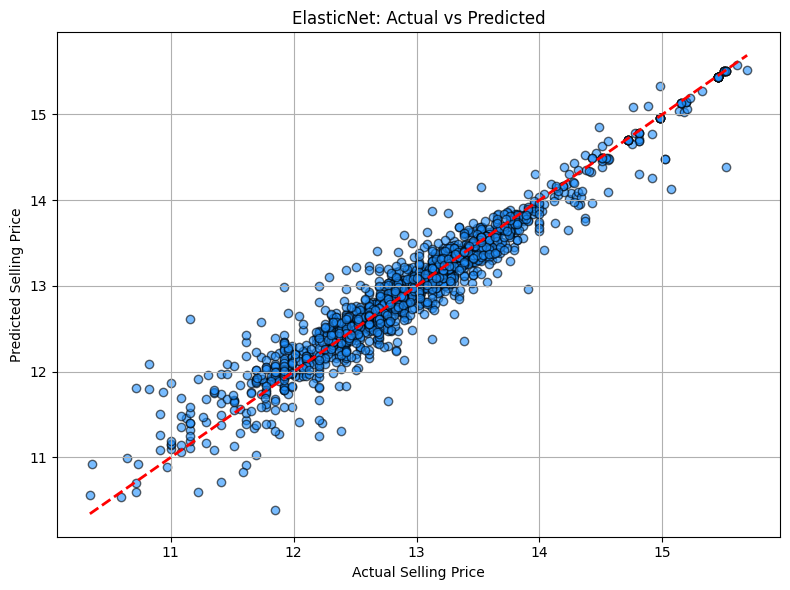

In [335]:
alpha = 0.001
l1_ratio = 0.9

elastic = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
elastic.fit(X_train_scaled, y_train)

y_pred = elastic.predict(X_test_scaled)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title("ElasticNet: Actual vs Predicted")
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.grid(True)
plt.tight_layout()
plt.show()